In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import ta
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# --- Load data ---
ticker = "AAPL"
end_time = datetime.now()
start_time = end_time - timedelta(days=60)
df = yf.download(ticker, start=start_time, end=end_time, interval="2m", auto_adjust=False).reset_index()
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

df.tail()

[*********************100%***********************]  1 of 1 completed


,Datetime,Adj Close,Close,High,Low,Open,Volume
6806,2025-06-27 19:50:00+00:00,200.699997,200.699997,201.110001,200.220001,200.979996,795995
6807,2025-06-27 19:52:00+00:00,200.839996,200.839996,200.919998,200.684998,200.690002,461898
6808,2025-06-27 19:54:00+00:00,201.059998,201.059998,201.240005,200.740005,200.850006,704428
6809,2025-06-27 19:56:00+00:00,200.860001,200.860001,201.270004,200.854996,201.059998,899205
6810,2025-06-27 19:58:00+00:00,201.100006,201.100006,201.160004,200.854996,200.869995,1420956


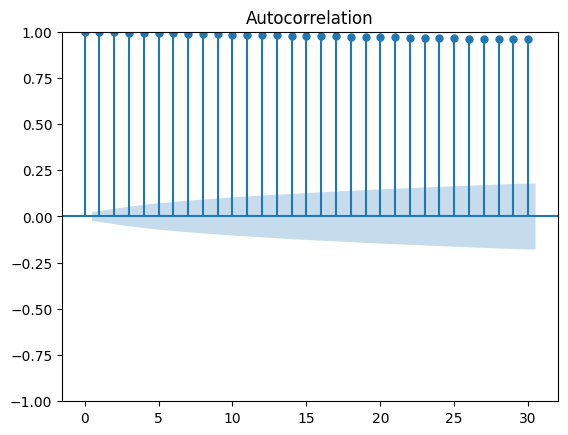

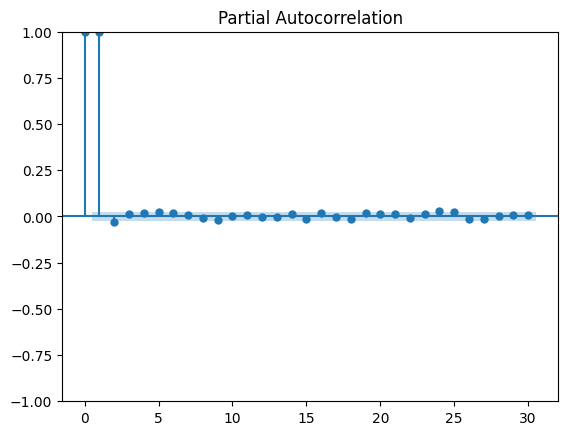

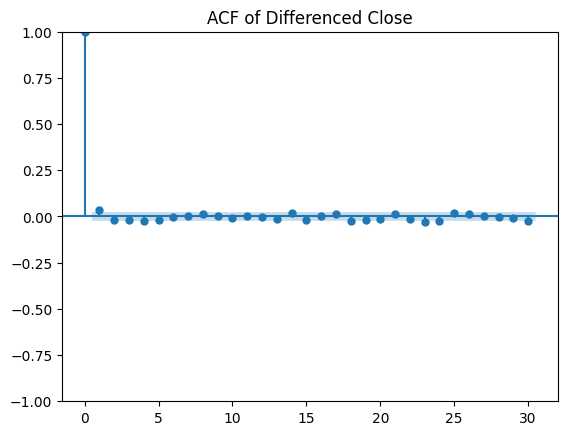

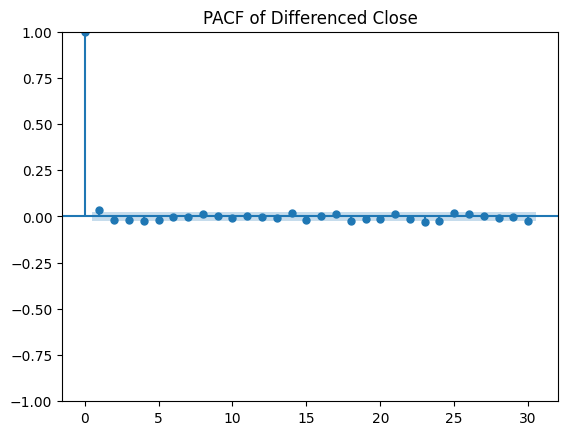

In [3]:
# RSI (Relative Strength Index)
df['RSI_14'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi().shift(1)

# MACD and Signal
macd = ta.trend.MACD(close=df['Close'])
df['MACD'] = macd.macd().shift(1)
df['MACD_signal'] = macd.macd_signal().shift(1)

# Bollinger Bands
bb = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
df['bb_high'] = bb.bollinger_hband().shift(1)
df['bb_low'] = bb.bollinger_lband().shift(1)
df['bb_pct'] = bb.bollinger_pband().shift(1)

# ATR (Average True Range)
df['ATR_14'] = ta.volatility.AverageTrueRange(
    high=df['High'], low=df['Low'], close=df['Close'], window=14
).average_true_range().shift(1)

# EMA (Exponential Moving Average)
df['EMA_10'] = ta.trend.EMAIndicator(close=df['Close'], window=10).ema_indicator().shift(1)

# --- Lag Feature Engineering ---
df['Close_t-1'] = df['Close'].shift(1)
df['Close_t-2'] = df['Close'].shift(2)
df['Volume_t-1'] = df['Volume'].shift(1)
df['Volume_t-2'] = df['Volume'].shift(2)
df['High_t-1'] = df['High'].shift(1)
df['Low_t-1'] = df['Low'].shift(1)

# --- Rolling Statistics ---
df['Close_roll_mean_5'] = df['Close'].rolling(window=5).mean()
df['Close_roll_std_5'] = df['Close'].rolling(window=5).std()
df['Volume_roll_mean_5'] = df['Volume'].rolling(window=5).mean()

# --- Returns & Diffs ---
df['Close_return_1'] = df['Close'].pct_change(1)
df['Close_diff_1'] = df['Close'].diff(1)
df['High_Low_range'] = df['High'] - df['Low']
df['OC_diff'] = df['Open'] - df['Close'].shift(1)

# --- Target: Predict Next Price ---
df['target'] = df['Close'].shift(-1)

# --- Drop missing values ---
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# --- Define Features and Target ---
features = [
    # Lag features
    'Close_t-1', 'Close_t-2',
    'Volume_t-1', 'Volume_t-2',
    'High_t-1', 'Low_t-1',

    # Rolling stats & derived
    'Close_roll_mean_5', 'Close_roll_std_5', 'Volume_roll_mean_5',
    'Close_return_1', 'Close_diff_1', 'High_Low_range', 'OC_diff',

    # Technical indicators
    'RSI_14', 'MACD', 'MACD_signal',
    'bb_high', 'bb_low', 'bb_pct',
    'ATR_14', 'EMA_10'
]

target = 'target'

# --- Train/test split ---
split_index = int(len(df) * 0.95)
df_train, df_test = df.iloc[:split_index], df.iloc[split_index:]
X_train, y_train = df_train[features], df_train[target]
X_test, y_test = df_test[features], df_test[target]

# --- Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Plot ACF & PACF (optional diagnostic) ---
plot_acf(df['Close'], lags=30)
plt.title("Autocorrelation")
plt.show()

plot_pacf(df['Close'], lags=30)
plt.title("Partial Autocorrelation")
plt.show()

plot_acf(df['Close_diff_1'].dropna(), lags=30)
plt.title("ACF of Differenced Close")
plt.show()

plot_pacf(df['Close_diff_1'].dropna(), lags=30)
plt.title("PACF of Differenced Close")
plt.show()



=== Linear Regression ===
MSE: 0.0229
MAE: 0.1012
R^2: 0.9620
Directional Accuracy: 0.4793


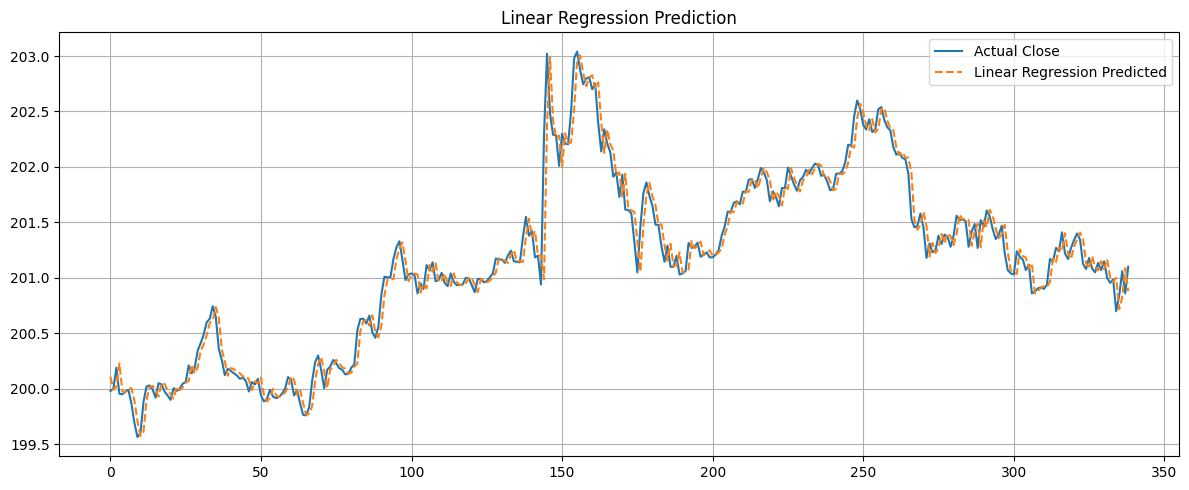

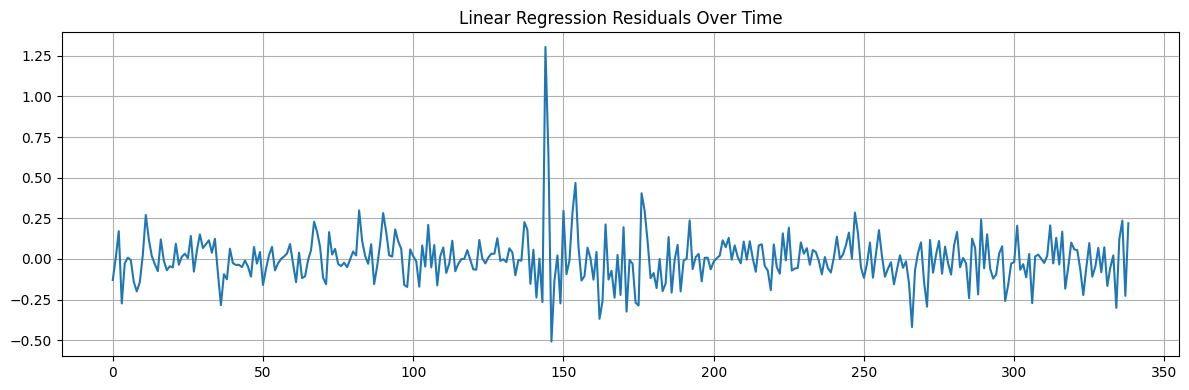

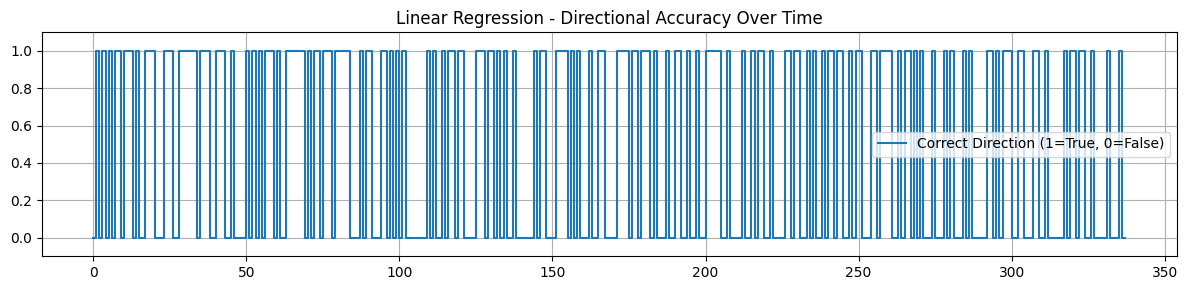

In [4]:
# --- Train Linear Regression Model ---
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

# --- Directional Accuracy (Linear Regression) ---
actual_diff_lr = y_test.values[1:] - y_test.values[:-1]
pred_diff_lr = lr_pred[1:] - lr_pred[:-1]
correct_direction_lr = np.sign(actual_diff_lr) == np.sign(pred_diff_lr)
directional_accuracy_lr = np.mean(correct_direction_lr)

# --- Evaluation Metrics ---
print("\n=== Linear Regression ===")
print(f"MSE: {mean_squared_error(y_test, lr_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, lr_pred):.4f}")
print(f"R^2: {r2_score(y_test, lr_pred):.4f}")
print(f"Directional Accuracy: {directional_accuracy_lr:.4f}")

# --- Plot Predictions ---
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual Close')
plt.plot(lr_pred, label='Linear Regression Predicted', linestyle='--')
plt.title("Linear Regression Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Residuals ---
lr_residuals = y_test - lr_pred
plt.figure(figsize=(12, 4))
plt.plot(lr_residuals.values)
plt.title("Linear Regression Residuals Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Direction Accuracy Plot ---
plt.figure(figsize=(12, 3))
plt.plot(correct_direction_lr.astype(int), label="Correct Direction (1=True, 0=False)", drawstyle='steps-post')
plt.title("Linear Regression - Directional Accuracy Over Time")
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



=== XGBoost Regression ===
MSE: 0.0268
MAE: 0.1115
R^2: 0.9556
Directional Accuracy: 0.5118


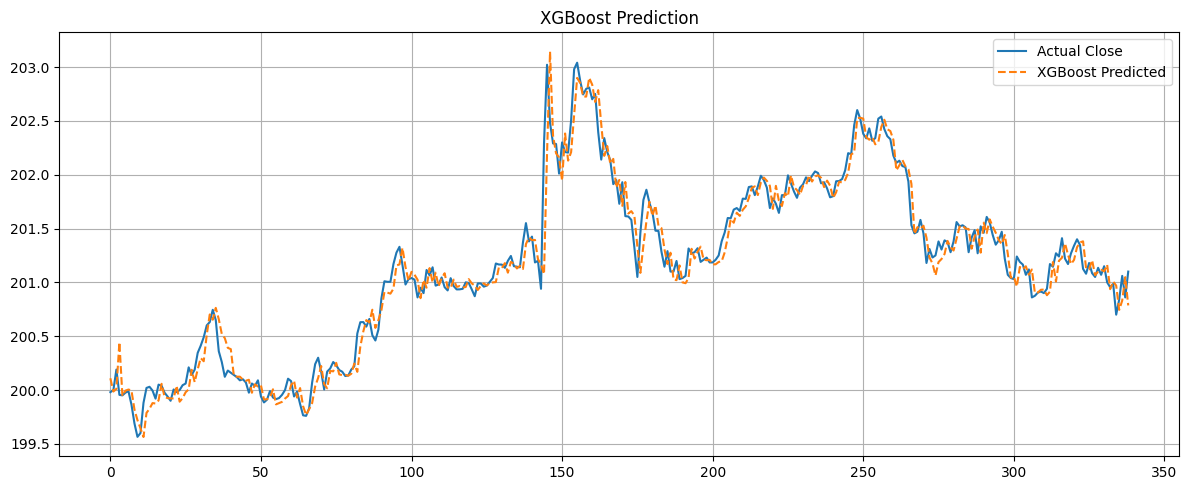

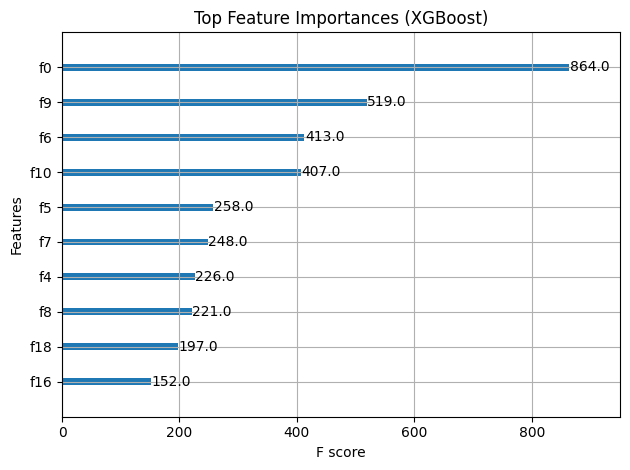

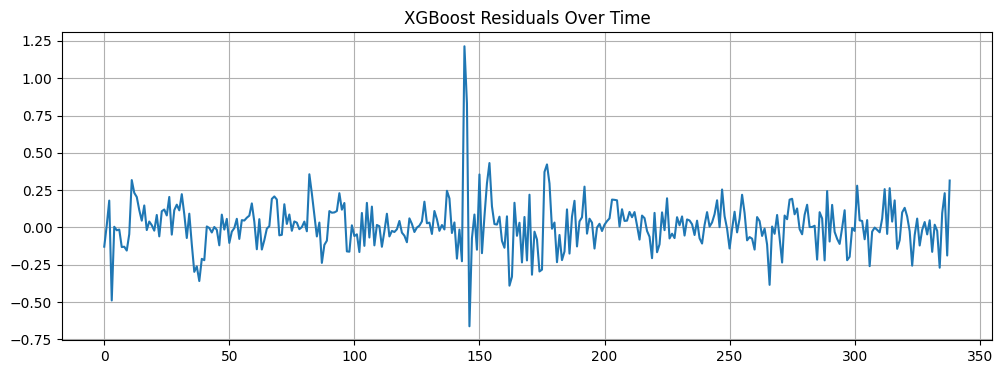

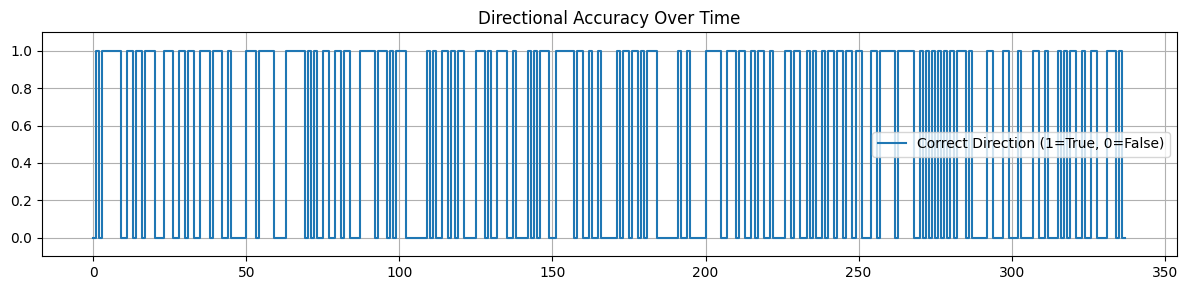


Feature Mapping (XGBoost → Original):
{'f0': 'Close_t-1', 'f1': 'Close_t-2', 'f2': 'Volume_t-1', 'f3': 'Volume_t-2', 'f4': 'High_t-1', 'f5': 'Low_t-1', 'f6': 'Close_roll_mean_5', 'f7': 'Close_roll_std_5', 'f8': 'Volume_roll_mean_5', 'f9': 'Close_return_1', 'f10': 'Close_diff_1', 'f11': 'High_Low_range', 'f12': 'OC_diff', 'f13': 'RSI_14', 'f14': 'MACD', 'f15': 'MACD_signal', 'f16': 'bb_high', 'f17': 'bb_low', 'f18': 'bb_pct', 'f19': 'ATR_14', 'f20': 'EMA_10'}


In [5]:
# --- Train XGBoost ---
xgb_model = XGBRegressor(
    n_estimators=1400,
    learning_rate=0.025,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

# --- Directional Accuracy ---
actual_diff = y_test.values[1:] - y_test.values[:-1]
pred_diff = xgb_pred[1:] - xgb_pred[:-1]
correct_direction = np.sign(actual_diff) == np.sign(pred_diff)
directional_accuracy = np.mean(correct_direction)

# --- Evaluation Metrics ---
print("\n=== XGBoost Regression ===")
print(f"MSE: {mean_squared_error(y_test, xgb_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred):.4f}")
print(f"R^2: {r2_score(y_test, xgb_pred):.4f}")
print(f"Directional Accuracy: {directional_accuracy:.4f}")

# --- Plot Predictions ---
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual Close')
plt.plot(xgb_pred, label='XGBoost Predicted', linestyle='--')
plt.title("XGBoost Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Feature Importances ---
plot_importance(xgb_model, max_num_features=10)
plt.title("Top Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

# --- Residuals ---
residuals = y_test - xgb_pred
plt.figure(figsize=(12, 4))
plt.plot(residuals.values)
plt.title("XGBoost Residuals Over Time")
plt.grid(True)
plt.show()

# --- Direction Accuracy Plot ---
plt.figure(figsize=(12, 3))
plt.plot(correct_direction.astype(int), label="Correct Direction (1=True, 0=False)", drawstyle='steps-post')
plt.title("Directional Accuracy Over Time")
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# --- Feature Mapping ---
feature_names = [f"f{i}" for i in range(len(features))]
print("\nFeature Mapping (XGBoost → Original):")
print(dict(zip(feature_names, features)))

C:\Users\diksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 64)              │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,465 (134.63 KB)

 Trainable params: 34,465 (134.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2558 - val_loss: 0.0415
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0645 - val_loss: 0.0016
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0134 - val_loss: 7.1732e-04
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0121 - val_loss: 0.0016
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0108 - val_loss: 9.7950e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0092 - val_loss: 6.4396e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0081 - val_loss: 0.0011
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0078 - val_loss: 7.5539e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0075 - val_loss: 8.7288e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0075 - val_loss: 8.2762e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0072 - val_loss: 6.9673e-04
Epoch 12/100
23/23 ━━━━━

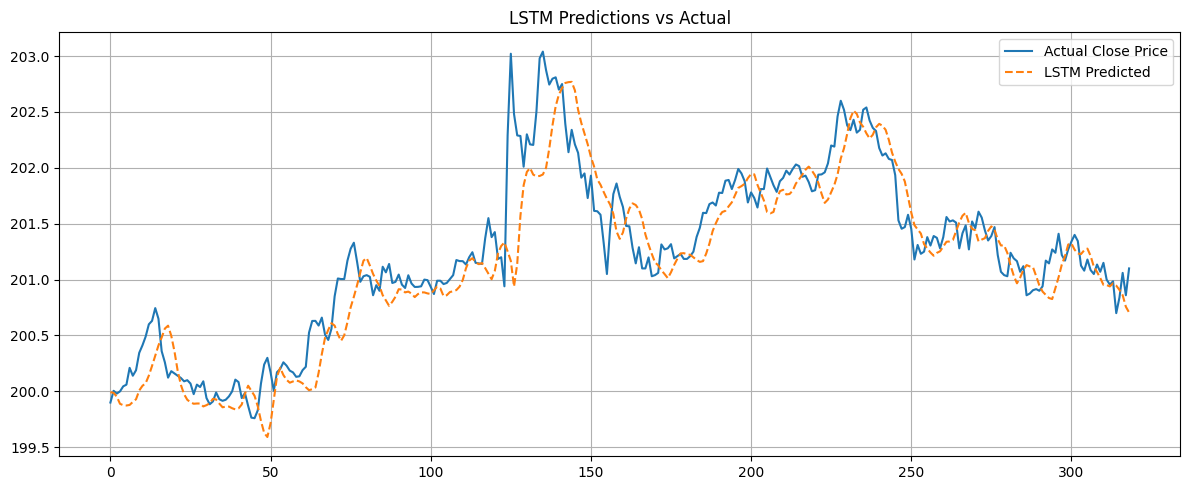

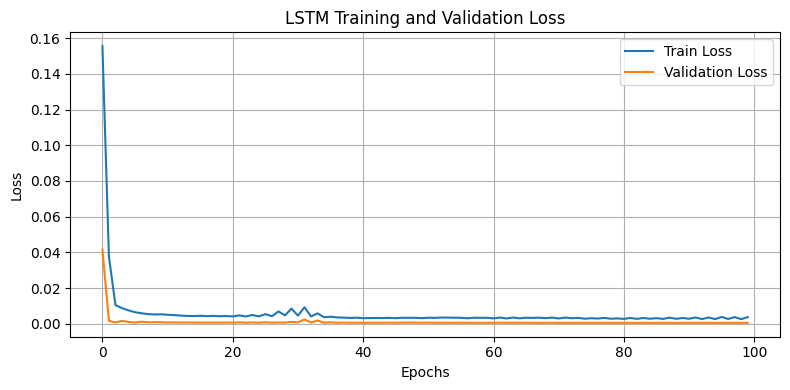

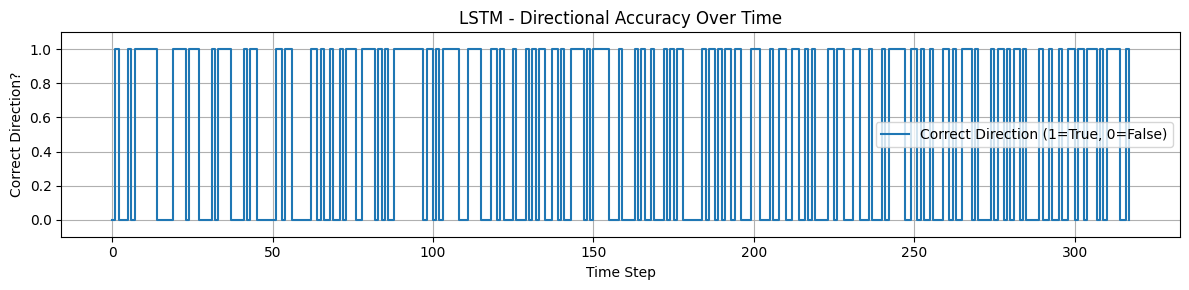

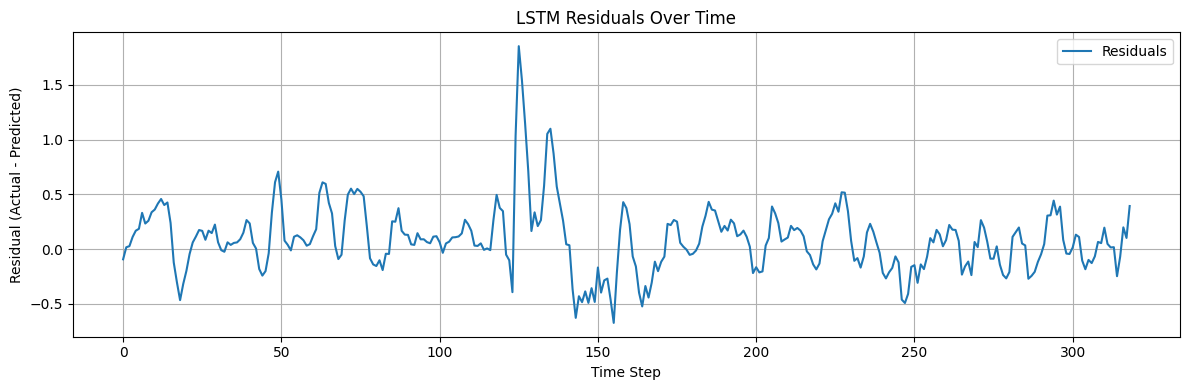

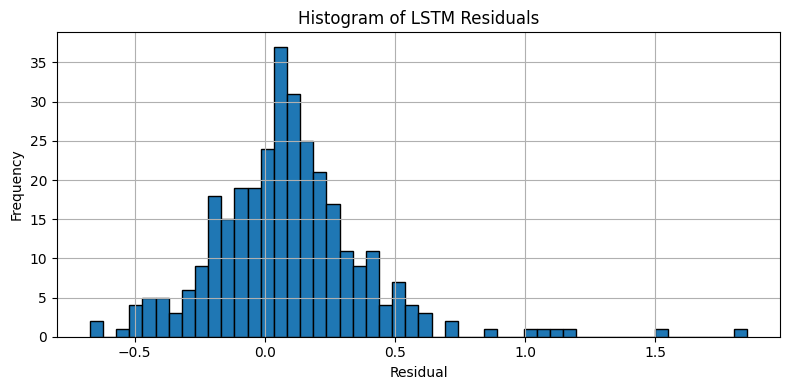

In [6]:
# --- Scale input features and target for LSTM ---
input_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_all_scaled = input_scaler.fit_transform(df[features])
y_all_scaled = target_scaler.fit_transform(df[[target]])

# --- Recreate sequences for LSTM ---
def create_sequences(X, y, time_steps=20):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i - time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Split again for full scaled version
X_train_full, X_test_full = X_all_scaled[:split_index], X_all_scaled[split_index:]
y_train_full, y_test_full = y_all_scaled[:split_index], y_all_scaled[split_index:]

# Create sequences for LSTM
TIME_STEPS = 20
X_train_seq, y_train_seq = create_sequences(X_train_full, y_train_full, time_steps=TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_full, y_test_full, time_steps=TIME_STEPS)

# --- Define LSTM Model ---
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Train Model ---
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)

# --- Predict ---
y_pred_scaled = model.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test_seq)

# --- Evaluation ---
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n=== LSTM Model Evaluation ===")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# --- Directional Accuracy ---
true_diff = y_true[1:] - y_true[:-1]
pred_diff = y_pred[1:] - y_pred[:-1]
directional_accuracy = np.mean(np.sign(true_diff) == np.sign(pred_diff))
print(f"Directional Accuracy: {directional_accuracy:.4f}")

# --- Plot Predictions ---
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Actual Close Price')
plt.plot(y_pred, label='LSTM Predicted', linestyle='--')
plt.title("LSTM Predictions vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Loss Curve ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Directional Accuracy Plot for LSTM ---
# Compute sign consistency between consecutive true and predicted moves
lstm_true_diff = y_true[1:] - y_true[:-1]
lstm_pred_diff = y_pred[1:] - y_pred[:-1]
correct_direction_lstm = (np.sign(lstm_true_diff) == np.sign(lstm_pred_diff))

# Plot it
plt.figure(figsize=(12, 3))
plt.plot(correct_direction_lstm.astype(int),
         label="Correct Direction (1=True, 0=False)",
         drawstyle='steps-post')
plt.title("LSTM - Directional Accuracy Over Time")
plt.ylim(-0.1, 1.1)
plt.xlabel("Time Step")
plt.ylabel("Correct Direction?")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Residuals for LSTM ---
lstm_residuals = y_true - y_pred

# Plot residuals over time
plt.figure(figsize=(12, 4))
plt.plot(lstm_residuals, label='Residuals')
plt.title("LSTM Residuals Over Time")
plt.xlabel("Time Step")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(lstm_residuals, bins=50, edgecolor='k')
plt.title("Histogram of LSTM Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()
